We compare the following two methods of getting RTT samples:

1. RTTs from TCP timestamps using the method described in "[New Methods for Passive Estimation of TCP Round-Trip Times](http://cobweb.cs.uga.edu/~kangli/src/pam05.pdf)"
2. RTTs from square waves as described in the [Proposal for adding a Spin Bit to QUIC](https://britram.github.io/draft-trammell-quic-spin/draft-trammell-quic-spin.html)

In particular, we want to find out how using method (1) in a probabilistic fashion fares against method (2) (where a single bit is added to every packet) in terms of accuracy.

We use the minimum value from method (1) as ground truth and compare to the minimum values of the other methods.

In [ ]:
STORE_PATH = '/tmp/short_trace.hdf5' # Path to datapoints from `00_extract_flows.ipynb`

In [ ]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from collections import namedtuple
from typing import Tuple, Callable, NamedTuple, Iterable, List
from itertools import chain
from functools import reduce, partial

import sys
sys.path.append('..')
from rtt import rtts_from_timestamps, rtts_from_square_wave

In [ ]:
with pd.HDFStore(STORE_PATH) as store:
    tcp_df = store['tcp_df']

## Compute

In [ ]:
# Group by flows and compute RTTs
def compute_rtts(rtt_fn: Callable[[Tuple[str, pd.DataFrame]], pd.DataFrame]) -> pd.DataFrame:
    rtt_df = pd.DataFrame()
    for flow in tcp_df.groupby('flow_hash'):
        rtt_df = pd.concat([rtt_df, rtt_fn(flow)])
    return rtt_df

tcp_df.set_index(['flow_hash', 'timestamp'])
timestamp_df = compute_rtts(rtts_from_timestamps)
squarewave_df = compute_rtts(rtts_from_square_wave)

## Evaluate

### Convert timedeltas to microseconds

In [ ]:
def convert_rtts_to_microseconds(rtt_df: pd.DataFrame) -> pd.DataFrame:
    rtt_df['rtt'] = rtt_df['rtt'] / np.timedelta64(1, 'us')

convert_rtts_to_microseconds(timestamp_df)
convert_rtts_to_microseconds(squarewave_df)

### Sample timestamp RTTs

In [ ]:
class Metric(NamedTuple):
    df: pd.DataFrame
    name: str
    bits_per_packet: float
    sample_rate: float = 1.0
        
def sample_metric(metric: Metric, sample_rate: float) -> Metric:
    """Subsamples the metric's `df` with `sample_rate` and recomputes `bits_per_packet`."""
    assert metric.sample_rate == 1.0, 'Metric has been sampled before!'
    sampled_df = metric.df.sample(frac=sample_rate)
    bits_per_packet= len(sampled_df) * metric.bits_per_packet / len(metric.df)
    return Metric(df=sampled_df,
                     name=metric.name, 
                     sample_rate=sample_rate, 
                     bits_per_packet=bits_per_packet)

TIMESTAMP_HEADER_SIZE = 64.0  # bits
timestamp_metric = Metric(df=timestamp_df, name='Timestamp', bits_per_packet=TIMESTAMP_HEADER_SIZE)
squarewave_metric = Metric(df=squarewave_df, name='Square Wave', bits_per_packet=1.0, )

SAMPLE_RATES = [0.5,0.25]
sampled_metrics = [sample_metric(timestamp_metric, rate) for rate in SAMPLE_RATES]

### Aggregate RTTs for each flow

In [ ]:
def aggregate_metric(metric: Metric) -> Metric:
    return metric._replace(df=metric.df.groupby('flow_hash').agg({
           'rtt': ['min', 'mean', 'std', 'count']
    }))

agg_timestamp_metric = aggregate_metric(timestamp_metric)
agg_squarewave_metric = aggregate_metric(squarewave_metric)
agg_sampled_metrics = [aggregate_metric(m) for m in sampled_metrics]

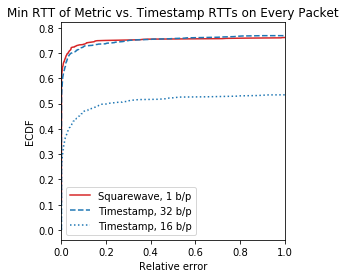

In [ ]:
def relative_errors(values: pd.Series, ground_truth: pd.Series) -> pd.Series:
    return (values - ground_truth) / ground_truth

def absolute_errors(values: pd.Series, ground_truth: pd.Series) -> pd.Series:
    return values - ground_truth

def ecdf(series: pd.Series) -> pd.Series:
    series = series.sort_values()
    cdf = np.linspace(0.,1.,len(series))
    return pd.Series(cdf, index=series)

Line = namedtuple('Line', ['style', 'color'])
def plot_error_ecdf(metrics: Iterable[Metric] = None, 
                    ground_truth: Metric = None, 
                    get_errors: Callable[[pd.Series,pd.Series], pd.Series] = None,
                    metric_to_series: Callable[[Metric], pd.Series] = None,
                    title: str = '',
                    xlabel: str = '',
                    lines: Iterable[Line] = None,
                    xlim: List[int] = None):
    plt.figure(figsize=(4,4))
    lines = lines or [Line(style='solid', color='#1f77b4') for _ in metrics]
    for metric, line in zip(metrics, lines):
        errors = relative_errors(metric_to_series(metric), metric_to_series(ground_truth))
        label = f'{metric.name}, {int(metric.bits_per_packet)} b/p'
        plt.plot(ecdf(errors), label=label, linestyle=line.style, color=line.color)
    plt.ylabel('ECDF')
    plt.xlabel(xlabel)
    plt.xlim(xlim)
    plt.title(title)
    plt.legend()
    
plot_rel_error_ecdf = partial(plot_error_ecdf, get_errors=relative_errors, xlabel='Relative error')
plot_abs_error_ecdf = partial(plot_error_ecdf, get_errors=relative_errors, xlabel='Absolute error')

plot_rel_error_ecdf(metrics=[agg_squarewave_metric, *agg_sampled_metrics],
                    ground_truth=agg_timestamp_metric,
                    metric_to_series=lambda m: m.df[('rtt', 'min')],
                    title='Min RTT of Metric vs. Timestamp RTTs on Every Packet',
                    lines=[Line('solid', '#d62728'), Line('--', '#1f77b4'), Line(':', '#1f77b4')],
                    xlim=[0, 1])

Only considering single flows, probabilistically adding a header to half of the values yields similar results as the square wave, but it requires 32 bits per packet: About 75% of the values have a relative error of less than 20% compared to "ground truth". When adding timestamps to every fourth packet, only 50% of the values would have a relative error lower than 20%.

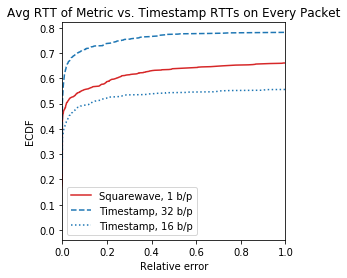

In [ ]:
plot_rel_error_ecdf(metrics=[agg_squarewave_metric, *agg_sampled_metrics],
                    ground_truth=agg_timestamp_metric,
                    metric_to_series=lambda m: m.df[('rtt', 'mean')],
                    title='Avg RTT of Metric vs. Timestamp RTTs on Every Packet',
                    lines=[Line('solid', '#d62728'), Line('--', '#1f77b4'), Line(':', '#1f77b4')],
                    xlim=[0, 1])

If we use the mean as the aggregation function, we see that the square wave is less accurate than 32 b/p timestamp, because in some cases my implementation overestimates the actual RTT. We could prevent this by only considering packets that have nonzero payloads.